In [1]:
%matplotlib widget

from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.utils import read_contracts_from_file
from contract_utils import *

## Scenario design analysis across viewpoints

Operating a space mission system requires allocating resources among tasks in order to satisfy operational requirements across multiple domain-specific viewpoints. For this case study, we developed scenarios in 4 viewpoints as summarized qualitative in the table below: 

| Viewpoint  | State | CHARGING | DSN | SBO | TCM |
|:----------:|:-----:|:--------:|:---:|:---:|:---:|
| Power      | `soc` |   +      |  -  |  -  |  -  |
| Science    | `d`   |   0      |  -  |  +  |  0  |
|            | `c`   |   0      |  0  |  +  |  0  |
| Navigation | `u`   |   +      |  +  |  -  |  +  |
|            | `r`   |   0      |  0  |  0  |  +  |
| Thermal    | `temp`|   -      |  -  |  -  |  +  |

The specification of the thermal scenario helped us realize that there are no significant thermal interactions among the scenario tasks that would constraint possible schedules. Therefore, it makes sense to omit the thermal viewpoint for the scenario analysis, leaving power, science & communication, and navigation as the significant viewpoints to use for optimizing the scenario design.

Now, we need to gather operational requirements for each of the three viewpoints.

### Operational requirements by viewpoint

Here, we adopt a simple methodology for exploring admissible scenario schedules as sets of possible solutions to the duration of each task. The idea is to elicit operational requirements as constraints on the entry/exit scenario state variables. We use a forcing technique to ensure that admissible solutions correspond to schedules where each task has a positive scheduled duration.

#### Power

The following specification defines a conservative operational regime that requires the battery state of charge to be at minimum 40% based on an initial state of charge of 80%; we force a non-trivial schedule by requiring that the duration of each task be no less than 10 units.


In [2]:
op_req_pwr1=PolyhedralContract.from_string(
    input_vars=[
        "soc1_entry",
        "duration_dsn1",
        "duration_charging2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    output_vars=[
        "output_soc1",
        "output_soc2",
        "output_soc3",
        "output_soc4",
        "output_soc5"
    ],
    assumptions=[
        "soc1_entry=80",
        "-duration_dsn1 <= -10",
        "-duration_charging2 <= -10",
        "-duration_sbo3 <= -10",
        "-duration_tcm_heating4 <= -10",
        "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
        "-output_soc1 <= -40",
        "-output_soc2 <= -40",
        "-output_soc3 <= -40",
        "-output_soc4 <= -40",
        "-output_soc5 <= -40",
    ])

The following specification defines a aggressive operational regime that requires the battery state of charge to be at minimum 10% based on an initial state of charge of 80%; we force a non-trivial schedule by requiring that the duration of each task be no less than 10 units.

In [3]:
op_req_pwr2=PolyhedralContract.from_string(
    input_vars=[
        "soc1_entry",
        "duration_dsn1",
        "duration_charging2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    output_vars=[
        "output_soc1",
        "output_soc2",
        "output_soc3",
        "output_soc4",
        "output_soc5"
    ],
    assumptions=[
        "soc1_entry=80",
        "-duration_dsn1 <= -10",
        "-duration_charging2 <= -10",
        "-duration_sbo3 <= -10",
        "-duration_tcm_heating4 <= -10",
        "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
        "-output_soc1 <= -10",
        "-output_soc2 <= -10",
        "-output_soc3 <= -10",
        "-output_soc4 <= -10",
        "-output_soc5 <= -10",
    ]
)

#### Science & Communication

It is useful to calculate how much science the avionics capability can deliver. For this, the following operational requirement specifies the initial conditions only. As before,  we force a non-trivial schedule by requiring that the duration of each task be no less than 10 units.

In [4]:
op_req_sci0=PolyhedralContract.from_string(
    input_vars=[
        "c1_entry",
        "d1_entry",
        "duration_dsn1",
        "duration_charging2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    output_vars=[
        "output_c5",
        "output_d5",
    ],
    assumptions=[
        "c1_entry=0",
        "d1_entry=100",
        "-duration_dsn1 <= -10",
        "-duration_charging2 <= -10",
        "-duration_sbo3 <= -10",
        "-duration_tcm_heating4 <= -10",
        "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
    ]
)


The following specification defines a conservative operational regime that requires the spacecraft to downlink at least 50% of its onboard science data storage while acquiring at least 60 units of science data from the initial conditions defined above. 

In [5]:
op_req_sci1=op_req_sci0.merge(PolyhedralContract.from_string(
    input_vars=[],
    output_vars=[
        "output_c5",
        "output_d5",
    ],
    assumptions=[],
    guarantees=[
        "-output_c5 <= -20",
        "-output_d5 <= -30",
    ]
))

The following specification defines an aggressive operational regime that requires the spacecraft to downlink at least 90% of its onboard science data storage while acquiring at least 80 units of science data from the initial conditions defined above.

In [6]:
op_req_sci2=op_req_sci0.merge(PolyhedralContract.from_string(
    input_vars=[],
    output_vars=[
        "output_c5",
        "output_d5",
    ],
    assumptions=[],
    guarantees=[
        "-output_c5 <= -80",
        "-output_d5 <= -90",
    ]
))

#### Navigation

The following specification defines a conservative operational regime that requires the spacecraft to reduce navigation uncertainty to below 40% from an initial level of 70% and to reduce trajectory relative distance to below 80% starting from an inital level of 100%. As before,  we force a non-trivial schedule by requiring that the duration of each task be no less than 10 units.

In [7]:
op_req_nav1=PolyhedralContract.from_string(
    input_vars=[
        "u1_entry",
        "r1_entry",
        "duration_dsn1",
        "duration_charging2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    output_vars=[
        "output_u5",
        "output_r5",
    ],
    assumptions=[
        "u1_entry=30",
        "r1_entry=100",
        "-duration_dsn1 <= -10",
        "-duration_charging2 <= -10",
        "-duration_sbo3 <= -10",
        "-duration_tcm_heating4 <= -10",
        "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
        "output_u5 <= 80",
        "output_r5 <= 80",
    ]
)

The following specification defines an aggressive operational regime that requires the spacecraft to reduce navigation uncertainty to below 20% from an initial level of 70% and to reduce trajectory relative distance to below 70% starting from an inital level of 100%. As before,  we force a non-trivial schedule by requiring that the duration of each task be no less than 10 units.

In [8]:
op_req_nav2=PolyhedralContract.from_string(
    input_vars=[
        "u1_entry",
        "r1_entry",
        "duration_dsn1",
        "duration_charging2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    output_vars=[
        "output_u5",
        "output_r5",
    ],
    assumptions=[
        "u1_entry=30",
        "r1_entry=100",
        "-duration_dsn1 <= -10",
        "-duration_charging2 <= -10",
        "-duration_sbo3 <= -10",
        "-duration_tcm_heating4 <= -10",
        "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
        "output_u5 <= 70",
        "output_r5 <= 80",
    ]
)

## Exploring combinations of operational scenario requirements

So far, we have defined conservative and aggressive operational requirements for each viewpoint. We can exploit the commutativity property of Pacti's contract merge operation to explore combinations of these requirements.

The first step involves reading the viewpoint-specific scenarios from their respective viewpoint-specific scenario case studies as shown below:

In [9]:
scenario_pwr = read_contracts_from_file(file_name="json/scenario_power.json")[0][0]
scenario_sci = read_contracts_from_file(file_name="json/scenario_science.json")[0][0]
scenario_nav = read_contracts_from_file(file_name="json/scenario_nav.json")[0][0]

Next, we explore algebraic combinations of scenarios and operational requirements with the confidence that the order in which we merge the requirements and scenarios is irrelevant. This flexibility gives an opportunity for collaborative design exploration where different teams could explore merging different combinations of viewpoints and requirement variants (e.g., conservative vs. aggressive).

In [10]:
all_scenarios = scenario_pwr.merge(scenario_sci).merge(scenario_nav)
print(f"all_scenarios:\n{all_scenarios}")

all_scenarios:
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5, d1_entry, c1_entry, u1_entry, r1_entry]
OutVars:[output_soc1, output_soc2, output_soc4, output_soc3, output_soc5, output_d1, output_c1, output_d2, output_c2, output_d4, output_c4, output_d3, output_c3, output_d5, output_c5, output_u1, output_r1, output_u2, output_r2, output_u4, output_r4, output_u3, output_r3, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_tcm_heating4 <= 0.0
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + output_soc2 <= 0.0
  3.0 duration_charging2 + output_soc1 - output_soc2 <= 

Next, we check whether there exists an admissible set of scenario schedules for all conservative operational requirements.

In [11]:
all_conservative_op_reqs = all_scenarios.merge(op_req_pwr1).merge(op_req_sci1).merge(op_req_nav1)
print(f"all_conservative_op_reqs=\n{all_conservative_op_reqs}")

all_conservative_op_reqs=
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5, d1_entry, c1_entry, u1_entry, r1_entry]
OutVars:[output_soc1, output_soc2, output_soc4, output_soc3, output_soc5, output_d1, output_c1, output_d2, output_c2, output_d4, output_c4, output_d3, output_c3, output_d5, output_c5, output_u1, output_r1, output_u2, output_r2, output_u4, output_r4, output_u3, output_r3, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_tcm_heating4 <= 0.0
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
  d1_entry = 100.0
  -d1_entry <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry = 100.0
  soc1_entry = 80.0
  -duration_dsn1 <= -10.0
  -duration_charging2 <= -10.0
  -duration_sbo3 <= -10.0
  -duration_tcm_heating4 <= -10.0
  -duration_tcm_deltav5 <= -10.0
  c1_entry = 0.0
  u1_entry = 30.0
]
G: [
  3.8 durati

In [12]:
all_aggressive_op_reqs = all_scenarios.merge(op_req_pwr2).merge(op_req_sci2).merge(op_req_nav2)
print(f"all_aggressive_op_reqs=\n{all_aggressive_op_reqs}")

all_aggressive_op_reqs=
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5, d1_entry, c1_entry, u1_entry, r1_entry]
OutVars:[output_soc1, output_soc2, output_soc4, output_soc3, output_soc5, output_d1, output_c1, output_d2, output_c2, output_d4, output_c4, output_d3, output_c3, output_d5, output_c5, output_u1, output_r1, output_u2, output_r2, output_u4, output_r4, output_u3, output_r3, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_tcm_heating4 <= 0.0
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
  d1_entry = 100.0
  -d1_entry <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry = 100.0
  soc1_entry = 80.0
  -duration_dsn1 <= -10.0
  -duration_charging2 <= -10.0
  -duration_sbo3 <= -10.0
  -duration_tcm_heating4 <= -10.0
  -duration_tcm_deltav5 <= -10.0
  c1_entry = 0.0
  u1_entry = 30.0
]
G: [
  -4.2 duratio

In [13]:
def show_bounds(c: PolyhedralContract):
    print("Task duration bounds:")
    print(f"    step1_dsn: "+str(c.get_variable_bounds("duration_dsn1")))
    print(f"    step2_charging: "+str(c.get_variable_bounds("duration_charging2")))
    print(f"    step3_sbo: "+str(c.get_variable_bounds("duration_sbo3")))
    print(f"    step4_tcm_heating: "+str(c.get_variable_bounds("duration_tcm_heating4")))
    print(f"    step5_tcm_deltav: "+str(c.get_variable_bounds("duration_tcm_deltav5")))

    print("Power bounds:")
    print(f"    soc5: "+str(c.get_variable_bounds("output_soc5")))
    print("Science bounds:")
    print(f"    d5: "+str(c.get_variable_bounds("output_d5")))
    print(f"    c5: "+str(c.get_variable_bounds("output_c5")))
    print("Navigation bounds:")
    print(f"    u5: "+str(c.get_variable_bounds("output_u5")))
    print(f"    r5: "+str(c.get_variable_bounds("output_r5")))

    max_soc = c.optimize("0.2 output_soc1 + 0.2 output_soc2 + 0.2 output_soc3 + 0.2 output_soc4 + 0.2 output_soc5", maximize=True)
    min_soc = c.optimize("0.2 output_soc1 + 0.2 output_soc2 + 0.2 output_soc3 + 0.2 output_soc4 + 0.2 output_soc5", maximize=False)
    print(f"[min, max] average SOC=[{min_soc}, {max_soc}]")

In [14]:
show_bounds(all_conservative_op_reqs)

Task duration bounds:
    step1_dsn: (10.0, 10.526315789473685)
    step2_charging: (11.25, 20.0)
    step3_sbo: (20.0, 33.0)
    step4_tcm_heating: (10.0, 28.571428571428573)
    step5_tcm_deltav: (40.0, 44.333333333333336)
Power bounds:
    soc5: (40.0, 53.0)
Science bounds:
    d5: (102.10526315789474, 180.0)
    c5: (60.0, 132.0)
Navigation bounds:
    u5: (72.2, 80.0)
    r5: (77.83333333333333, 80.0)
[min, max] average SOC=[58.800000000000004, 69.6]


In [15]:
show_bounds(all_aggressive_op_reqs)

Task duration bounds:
    step1_dsn: (10.0, 18.42105263157895)
    step2_charging: (10.0, 30.0)
    step3_sbo: (36.66666666666667, 63.0)
    step4_tcm_heating: (10.0, 47.61904761904761)
    step5_tcm_deltav: (40.0, 46.666666666666664)
Power bounds:
    soc5: (10.0, 36.33333333333333)
Science bounds:
    d5: (110.00000000000001, 300.0)
    c5: (110.00000000000001, 252.0)
Navigation bounds:
    u5: (60.0, 70.0)
    r5: (76.66666666666667, 80.0)
[min, max] average SOC=[32.13333333333333, 59.599999999999994]


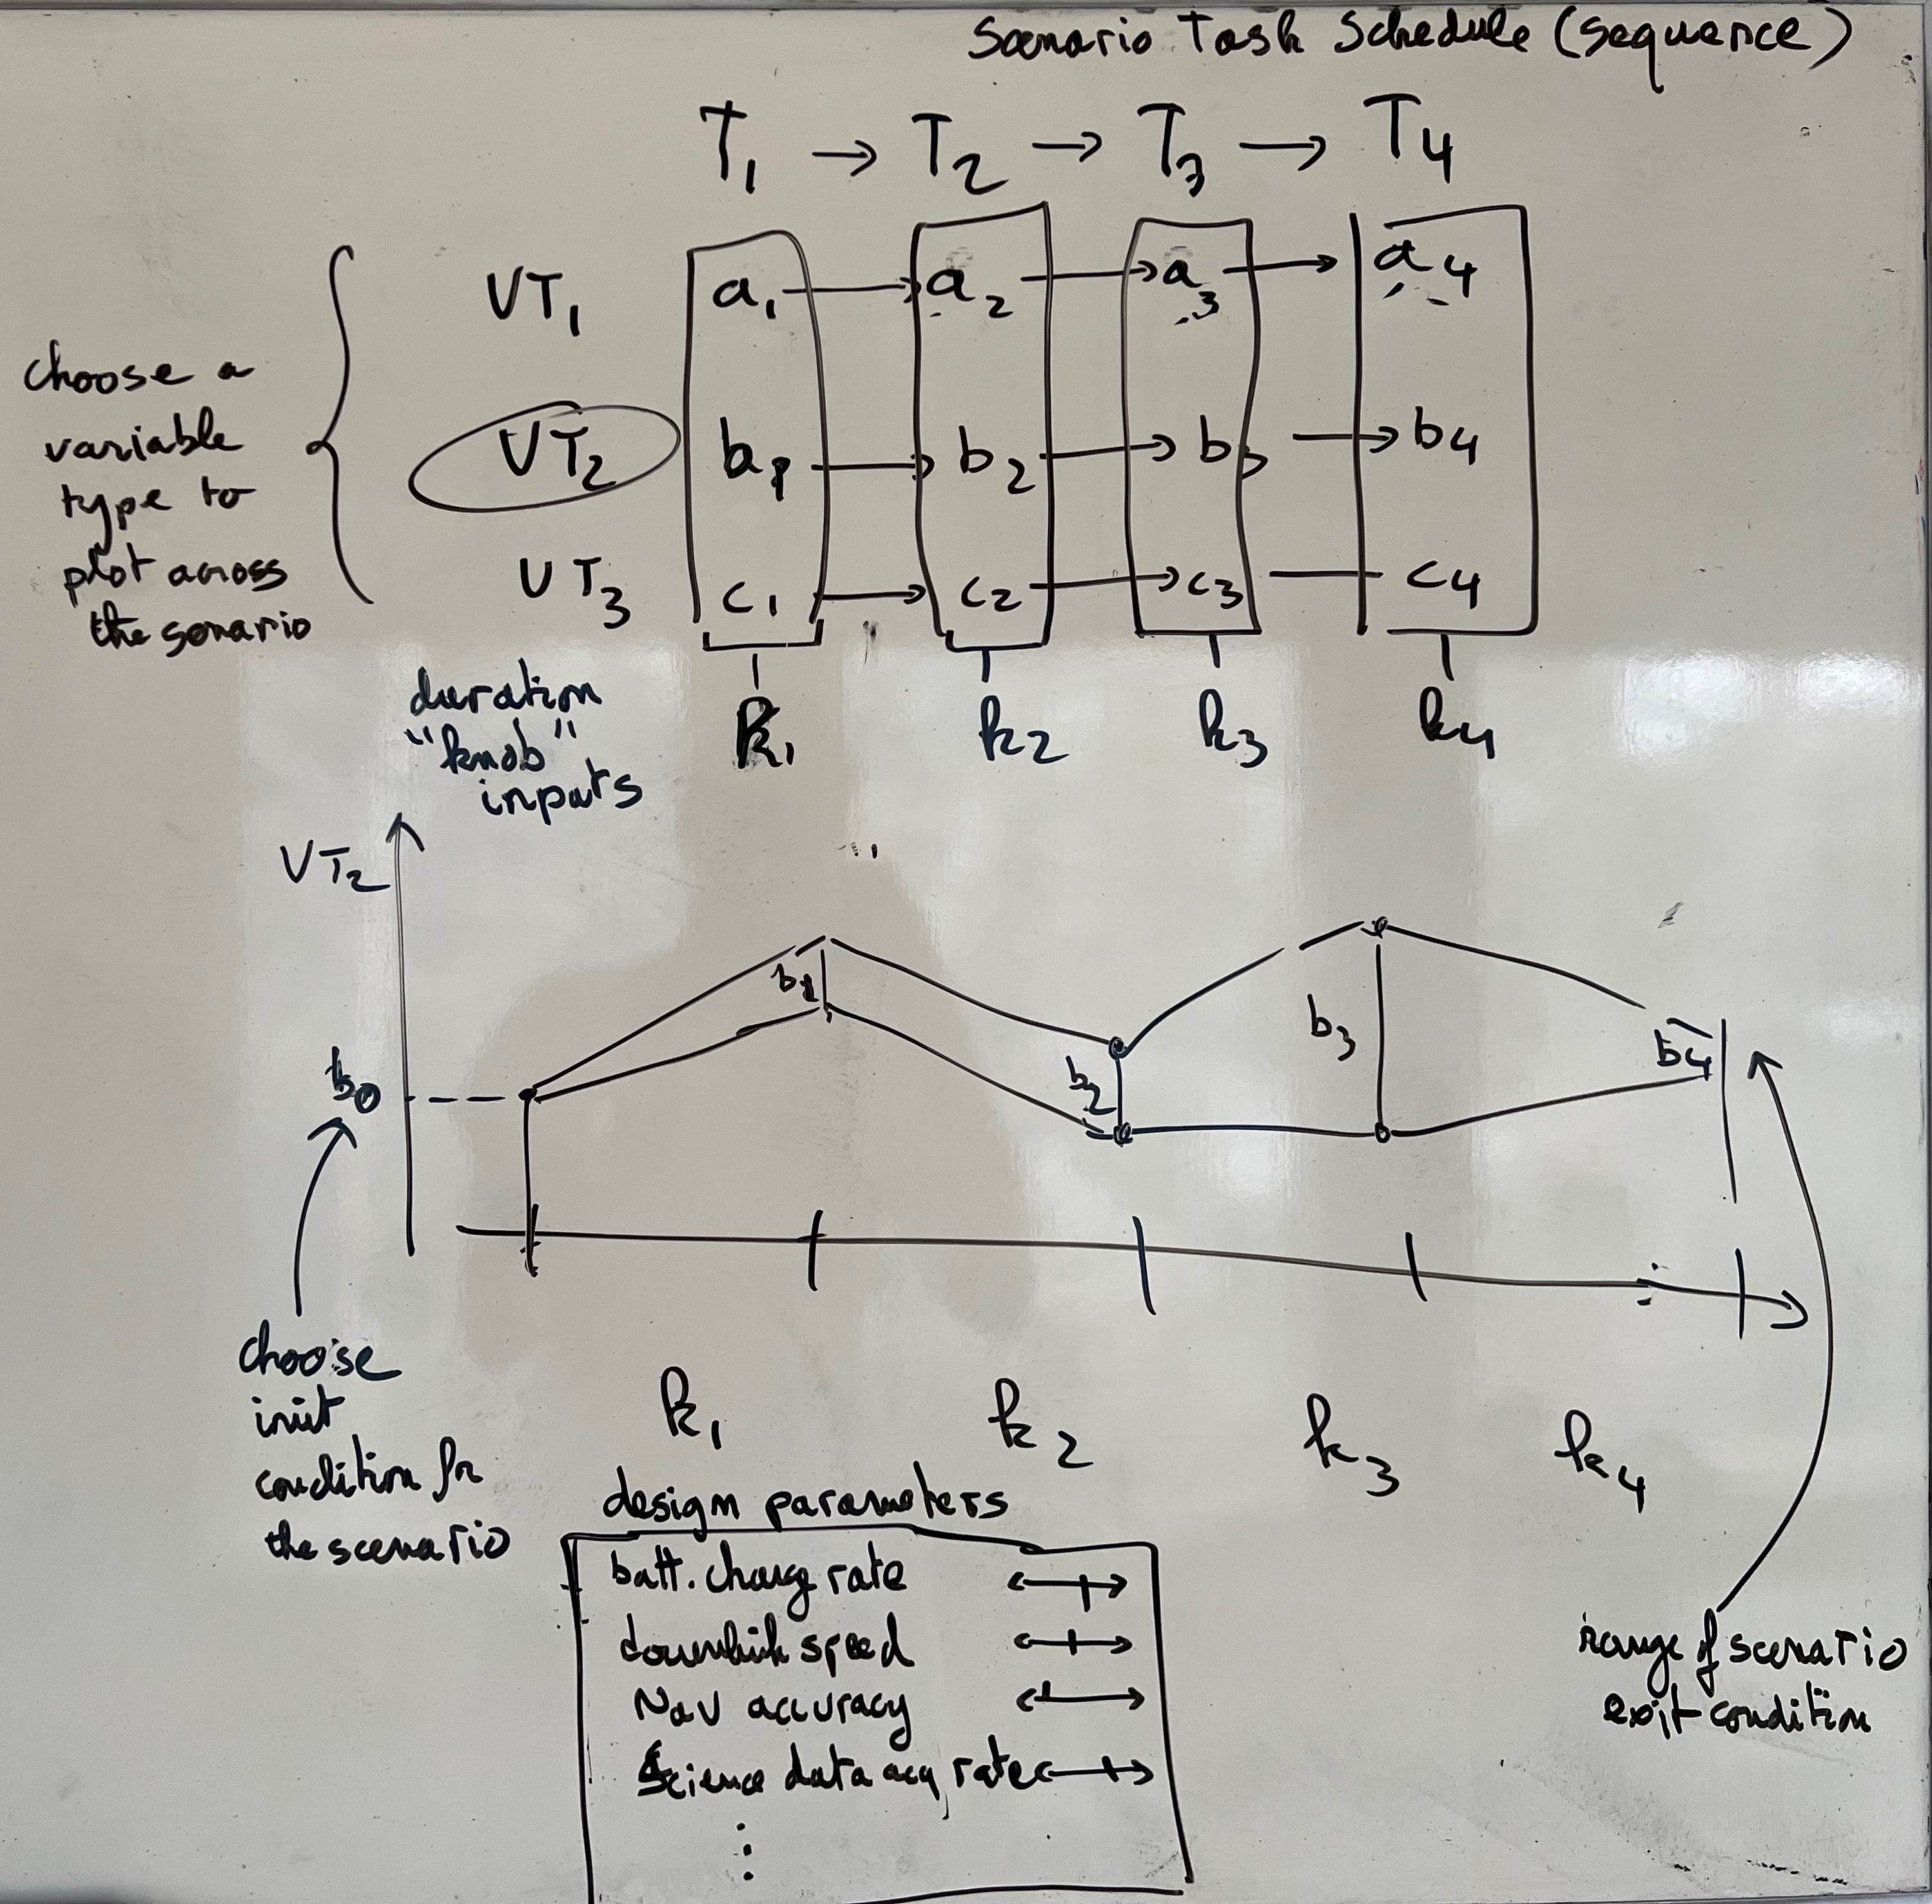

In [16]:
display.Image(b64decode(pacti_interactive_scenario_plot_concept))